# CIFAR-10 Classification (Feedforward)


- Data preprocessing (normalize, one-hot labels, 50k/10k split)
- A feedforward neural network matching input shape 32x32x3
- Justification of architecture and activation choices
- Comparison of two loss functions vs categorical crossentropy
- Optimizer choice and learning-rate discussion
- Training using backpropagation (Keras) with ModelCheckpoint + callbacks
- Evaluation: accuracy, precision, recall, F1, confusion matrix
- Minimal NumPy 2-layer backprop demo (educational)

In [13]:
# Environment & imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

print('tf:', tf.__version__)

tf: 2.20.0


In [14]:
# Hyperparameters
HPARAMS = {
    'batch_size': 128,
    'epochs': 50,
    'learning_rate': 1e-3,
    'seed': 42
}
np.random.seed(HPARAMS['seed'])
tf.random.set_seed(HPARAMS['seed'])
HPARAMS

{'batch_size': 128, 'epochs': 50, 'learning_rate': 0.001, 'seed': 42}

In [15]:
# Data loading and preprocessing
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)
print('x_train', x_train.shape, 'y_train', y_train_cat.shape)
print('x_test', x_test.shape, 'y_test', y_test_cat.shape)

x_train (50000, 32, 32, 3) y_train (50000, 10)
x_test (10000, 32, 32, 3) y_test (10000, 10)


## Network architecture (feedforward) and justification

We use a fully-connected (feedforward) network: Input flattened (32x32x3) → Dense(1024) → Dense(512) → Dense(256) → Dense(10 softmax). BatchNorm and Dropout included to stabilize and regularize training.

In [16]:
def build_feedforward_model(input_shape=(32,32,3), num_classes=10, activation='relu'):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(1024, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_feedforward_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,811,594 (14.54 MB)

 Trainable params: 3,808,522 (14.53 MB)

 Non-trainable params: 3,072 (12.00 KB)

## Activation functions chosen and their role
We will use ReLU (default) and tanh (alternative). ReLU avoids saturation for positive inputs and speeds gradient flow; tanh is zero-centered but can saturate. In backpropagation, the derivative of the activation scales gradients propagated backward.

In [17]:
# Training helper with callbacks (ModelCheckpoint + EarlyStopping + ReduceLROnPlateau)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
def train_and_evaluate(model, model_name, loss='categorical_crossentropy', optimizer=None, epochs=None, batch_size=None, use_generator=False, datagen=None):
    if epochs is None: epochs = HPARAMS['epochs']
    if batch_size is None: batch_size = HPARAMS['batch_size']
    if optimizer is None: optimizer = keras.optimizers.Adam(learning_rate=HPARAMS['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1), ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)]
    os.makedirs('checkpoints', exist_ok=True)
    ckpt_path = f'checkpoints/{model_name}_best.h5'
    mc = ModelCheckpoint(filepath=ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
    callbacks.append(mc)
    if use_generator and datagen is not None:
        steps = max(1, x_train.shape[0] // batch_size)
        history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=batch_size), epochs=epochs, validation_data=(x_test, y_test_cat), callbacks=callbacks, steps_per_epoch=steps, verbose=2)
    else:
        history = model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test_cat), callbacks=callbacks, verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
    print(f'{model_name} test loss: {test_loss:.4f}  test acc: {test_acc:.4f}')
    return history, ckpt_path, (test_loss, test_acc)

Epoch 1/50

Epoch 1: val_loss improved from None to 1.80798, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 1: val_loss improved from None to 1.80798, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 11s - 28ms/step - accuracy: 0.3085 - loss: 2.0072 - val_accuracy: 0.3417 - val_loss: 1.8080 - learning_rate: 1.0000e-03
Epoch 2/50
Epoch 2/50

Epoch 2: val_loss improved from 1.80798 to 1.73553, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 2: val_loss improved from 1.80798 to 1.73553, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 11s - 27ms/step - accuracy: 0.3731 - loss: 1.7600 - val_accuracy: 0.3739 - val_loss: 1.7355 - learning_rate: 1.0000e-03
Epoch 3/50
Epoch 3/50

Epoch 3: val_loss did not improve from 1.73553
391/391 - 10s - 24ms/step - accuracy: 0.3953 - loss: 1.6866 - val_accuracy: 0.3701 - val_loss: 1.7662 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 3: val_loss did not improve from 1.73553
391/391 - 10s - 24ms/step - accuracy: 0.3953 - loss: 1.6866 - val_accuracy: 0.3701 - val_loss: 1.7662 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 1.73553 to 1.71295, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 4: val_loss improved from 1.73553 to 1.71295, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 9s - 24ms/step - accuracy: 0.4054 - loss: 1.6559 - val_accuracy: 0.3857 - val_loss: 1.7130 - learning_rate: 1.0000e-03
Epoch 5/50
Epoch 5/50

Epoch 5: val_loss improved from 1.71295 to 1.64736, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 5: val_loss improved from 1.71295 to 1.64736, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 10s - 25ms/step - accuracy: 0.4104 - loss: 1.6397 - val_accuracy: 0.4058 - val_loss: 1.6474 - learning_rate: 1.0000e-03
Epoch 6/50
Epoch 6/50

Epoch 6: val_loss improved from 1.64736 to 1.57716, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 6: val_loss improved from 1.64736 to 1.57716, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 10s - 27ms/step - accuracy: 0.4145 - loss: 1.6303 - val_accuracy: 0.4391 - val_loss: 1.5772 - learning_rate: 1.0000e-03
Epoch 7/50
Epoch 7/50

Epoch 7: val_loss improved from 1.57716 to 1.55145, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 7: val_loss improved from 1.57716 to 1.55145, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 12s - 31ms/step - accuracy: 0.4195 - loss: 1.6155 - val_accuracy: 0.4401 - val_loss: 1.5515 - learning_rate: 1.0000e-03
Epoch 8/50
Epoch 8/50

Epoch 8: val_loss improved from 1.55145 to 1.47913, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 8: val_loss improved from 1.55145 to 1.47913, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 11s - 28ms/step - accuracy: 0.4225 - loss: 1.6075 - val_accuracy: 0.4703 - val_loss: 1.4791 - learning_rate: 1.0000e-03
Epoch 9/50
Epoch 9/50

Epoch 9: val_loss did not improve from 1.47913
391/391 - 10s - 27ms/step - accuracy: 0.4290 - loss: 1.5879 - val_accuracy: 0.4705 - val_loss: 1.4853 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 9: val_loss did not improve from 1.47913
391/391 - 10s - 27ms/step - accuracy: 0.4290 - loss: 1.5879 - val_accuracy: 0.4705 - val_loss: 1.4853 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: val_loss did not improve from 1.47913
391/391 - 10s - 27ms/step - accuracy: 0.4317 - loss: 1.5848 - val_accuracy: 0.4331 - val_loss: 1.5470 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 10: val_loss did not improve from 1.47913
391/391 - 10s - 27ms/step - accuracy: 0.4317 - loss: 1.5848 - val_accuracy: 0.4331 - val_loss: 1.5470 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: val_loss did not improve from 1.47913
391/391 - 10s - 26ms/step - accuracy:

391/391 - 10s - 27ms/step - accuracy: 0.4399 - loss: 1.5644 - val_accuracy: 0.4732 - val_loss: 1.4661 - learning_rate: 1.0000e-03
Epoch 13/50
Epoch 13/50

Epoch 13: val_loss improved from 1.46610 to 1.45569, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 13: val_loss improved from 1.46610 to 1.45569, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 20s - 51ms/step - accuracy: 0.4389 - loss: 1.5652 - val_accuracy: 0.4752 - val_loss: 1.4557 - learning_rate: 1.0000e-03
Epoch 14/50
Epoch 14/50

Epoch 14: val_loss improved from 1.45569 to 1.45118, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 14: val_loss improved from 1.45569 to 1.45118, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 10s - 26ms/step - accuracy: 0.4450 - loss: 1.5525 - val_accuracy: 0.4795 - val_loss: 1.4512 - learning_rate: 1.0000e-03
Epoch 15/50
Epoch 15/50

Epoch 15: val_loss improved from 1.45118 to 1.44132, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 15: val_loss improved from 1.45118 to 1.44132, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 11s - 27ms/step - accuracy: 0.4463 - loss: 1.5498 - val_accuracy: 0.4836 - val_loss: 1.4413 - learning_rate: 1.0000e-03
Epoch 16/50
Epoch 16/50

Epoch 16: val_loss did not improve from 1.44132
391/391 - 11s - 27ms/step - accuracy: 0.4505 - loss: 1.5388 - val_accuracy: 0.4698 - val_loss: 1.4792 - learning_rate: 1.0000e-03
Epoch 17/50

Epoch 16: val_loss did not improve from 1.44132
391/391 - 11s - 27ms/step - accuracy: 0.4505 - loss: 1.5388 - val_accuracy: 0.4698 - val_loss: 1.4792 - learning_rate: 1.0000e-03
Epoch 17/50

Epoch 17: val_loss improved from 1.44132 to 1.41996, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 17: val_loss improved from 1.44132 to 1.41996, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 19s - 49ms/step - accuracy: 0.4540 - loss: 1.5271 - val_accuracy: 0.4931 - val_loss: 1.4200 - learning_rate: 1.0000e-03
Epoch 18/50
Epoch 18/50

Epoch 18: val_loss did not improve from 1.41996
391/391 - 10s - 25ms/step - accuracy: 0.4499 - loss: 1.5324 - val_accuracy: 0.4881 - val_loss: 1.4308 - learning_rate: 1.0000e-03
Epoch 19/50

Epoch 18: val_loss did not improve from 1.41996
391/391 - 10s - 25ms/step - accuracy: 0.4499 - loss: 1.5324 - val_accuracy: 0.4881 - val_loss: 1.4308 - learning_rate: 1.0000e-03
Epoch 19/50

Epoch 19: val_loss did not improve from 1.41996
391/391 - 10s - 25ms/step - accuracy: 0.4533 - loss: 1.5262 - val_accuracy: 0.4877 - val_loss: 1.4353 - learning_rate: 1.0000e-03
Epoch 20/50

Epoch 19: val_loss did not improve from 1.41996
391/391 - 10s - 25ms/step - accuracy: 0.4533 - loss: 1.5262 - val_accuracy: 0.4877 - val_loss: 1.4353 - learning_rate: 1.0000e-03
Epoch 20/50

Epoch 20: val_loss did not improve from 1.41996
391/391 - 10s - 27ms/step - accur

391/391 - 10s - 27ms/step - accuracy: 0.4574 - loss: 1.5126 - val_accuracy: 0.4939 - val_loss: 1.4007 - learning_rate: 1.0000e-03
Epoch 22/50
Epoch 22/50

Epoch 22: val_loss did not improve from 1.40067
391/391 - 10s - 26ms/step - accuracy: 0.4578 - loss: 1.5167 - val_accuracy: 0.4859 - val_loss: 1.4320 - learning_rate: 1.0000e-03
Epoch 23/50

Epoch 22: val_loss did not improve from 1.40067
391/391 - 10s - 26ms/step - accuracy: 0.4578 - loss: 1.5167 - val_accuracy: 0.4859 - val_loss: 1.4320 - learning_rate: 1.0000e-03
Epoch 23/50

Epoch 23: val_loss improved from 1.40067 to 1.39054, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 23: val_loss improved from 1.40067 to 1.39054, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 11s - 27ms/step - accuracy: 0.4626 - loss: 1.5025 - val_accuracy: 0.5007 - val_loss: 1.3905 - learning_rate: 1.0000e-03
Epoch 24/50
Epoch 24/50

Epoch 24: val_loss did not improve from 1.39054
391/391 - 19s - 50ms/step - accuracy: 0.4632 - loss: 1.4969 - val_accuracy: 0.4976 - val_loss: 1.4054 - learning_rate: 1.0000e-03
Epoch 25/50

Epoch 24: val_loss did not improve from 1.39054
391/391 - 19s - 50ms/step - accuracy: 0.4632 - loss: 1.4969 - val_accuracy: 0.4976 - val_loss: 1.4054 - learning_rate: 1.0000e-03
Epoch 25/50

Epoch 25: val_loss did not improve from 1.39054
391/391 - 10s - 25ms/step - accuracy: 0.4673 - loss: 1.4880 - val_accuracy: 0.5009 - val_loss: 1.3908 - learning_rate: 1.0000e-03
Epoch 26/50

Epoch 25: val_loss did not improve from 1.39054
391/391 - 10s - 25ms/step - accuracy: 0.4673 - loss: 1.4880 - val_accuracy: 0.5009 - val_loss: 1.3908 - learning_rate: 1.0000e-03
Epoch 26/50

Epoch 26: val_loss did not improve from 1.39054
391/391 - 10s - 25ms/step - accur

391/391 - 10s - 25ms/step - accuracy: 0.4849 - loss: 1.4386 - val_accuracy: 0.5221 - val_loss: 1.3481 - learning_rate: 5.0000e-04
Epoch 31/50
Epoch 31/50

Epoch 31: val_loss did not improve from 1.34810
391/391 - 10s - 25ms/step - accuracy: 0.4886 - loss: 1.4316 - val_accuracy: 0.5079 - val_loss: 1.3656 - learning_rate: 5.0000e-04
Epoch 32/50

Epoch 31: val_loss did not improve from 1.34810
391/391 - 10s - 25ms/step - accuracy: 0.4886 - loss: 1.4316 - val_accuracy: 0.5079 - val_loss: 1.3656 - learning_rate: 5.0000e-04
Epoch 32/50

Epoch 32: val_loss improved from 1.34810 to 1.34540, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 32: val_loss improved from 1.34810 to 1.34540, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 10s - 27ms/step - accuracy: 0.4866 - loss: 1.4335 - val_accuracy: 0.5195 - val_loss: 1.3454 - learning_rate: 5.0000e-04
Epoch 33/50
Epoch 33/50

Epoch 33: val_loss did not improve from 1.34540
391/391 - 11s - 28ms/step - accuracy: 0.4882 - loss: 1.4302 - val_accuracy: 0.5026 - val_loss: 1.3921 - learning_rate: 5.0000e-04
Epoch 34/50

Epoch 33: val_loss did not improve from 1.34540
391/391 - 11s - 28ms/step - accuracy: 0.4882 - loss: 1.4302 - val_accuracy: 0.5026 - val_loss: 1.3921 - learning_rate: 5.0000e-04
Epoch 34/50

Epoch 34: val_loss did not improve from 1.34540
391/391 - 19s - 48ms/step - accuracy: 0.4867 - loss: 1.4259 - val_accuracy: 0.5155 - val_loss: 1.3533 - learning_rate: 5.0000e-04
Epoch 35/50

Epoch 34: val_loss did not improve from 1.34540
391/391 - 19s - 48ms/step - accuracy: 0.4867 - loss: 1.4259 - val_accuracy: 0.5155 - val_loss: 1.3533 - learning_rate: 5.0000e-04
Epoch 35/50

Epoch 35: val_loss did not improve from 1.34540
391/391 - 10s - 24ms/step - accur

391/391 - 11s - 27ms/step - accuracy: 0.4934 - loss: 1.4200 - val_accuracy: 0.5187 - val_loss: 1.3389 - learning_rate: 5.0000e-04
Epoch 37/50
Epoch 37/50

Epoch 37: val_loss did not improve from 1.33890
391/391 - 11s - 28ms/step - accuracy: 0.4912 - loss: 1.4198 - val_accuracy: 0.5175 - val_loss: 1.3520 - learning_rate: 5.0000e-04
Epoch 38/50

Epoch 37: val_loss did not improve from 1.33890
391/391 - 11s - 28ms/step - accuracy: 0.4912 - loss: 1.4198 - val_accuracy: 0.5175 - val_loss: 1.3520 - learning_rate: 5.0000e-04
Epoch 38/50

Epoch 38: val_loss improved from 1.33890 to 1.32879, saving model to checkpoints/FFN-ReLU-full50_best.h5

Epoch 38: val_loss improved from 1.33890 to 1.32879, saving model to checkpoints/FFN-ReLU-full50_best.h5


391/391 - 10s - 27ms/step - accuracy: 0.4944 - loss: 1.4141 - val_accuracy: 0.5260 - val_loss: 1.3288 - learning_rate: 5.0000e-04
Epoch 39/50
Epoch 39/50

Epoch 39: val_loss did not improve from 1.32879
391/391 - 10s - 26ms/step - accuracy: 0.4933 - loss: 1.4094 - val_accuracy: 0.5221 - val_loss: 1.3388 - learning_rate: 5.0000e-04
Epoch 40/50

Epoch 39: val_loss did not improve from 1.32879
391/391 - 10s - 26ms/step - accuracy: 0.4933 - loss: 1.4094 - val_accuracy: 0.5221 - val_loss: 1.3388 - learning_rate: 5.0000e-04
Epoch 40/50

Epoch 40: val_loss did not improve from 1.32879
391/391 - 10s - 26ms/step - accuracy: 0.4941 - loss: 1.4080 - val_accuracy: 0.5143 - val_loss: 1.3584 - learning_rate: 5.0000e-04
Epoch 41/50

Epoch 40: val_loss did not improve from 1.32879
391/391 - 10s - 26ms/step - accuracy: 0.4941 - loss: 1.4080 - val_accuracy: 0.5143 - val_loss: 1.3584 - learning_rate: 5.0000e-04
Epoch 41/50

Epoch 41: val_loss did not improve from 1.32879
391/391 - 10s - 26ms/step - accur

391/391 - 10s - 26ms/step - accuracy: 0.5028 - loss: 1.3936 - val_accuracy: 0.5219 - val_loss: 1.3270 - learning_rate: 2.5000e-04
Epoch 44/50
Epoch 44/50

Epoch 44: val_loss did not improve from 1.32701
391/391 - 11s - 27ms/step - accuracy: 0.5046 - loss: 1.3863 - val_accuracy: 0.5183 - val_loss: 1.3394 - learning_rate: 2.5000e-04
Epoch 45/50

Epoch 44: val_loss did not improve from 1.32701
391/391 - 11s - 27ms/step - accuracy: 0.5046 - loss: 1.3863 - val_accuracy: 0.5183 - val_loss: 1.3394 - learning_rate: 2.5000e-04
Epoch 45/50

Epoch 45: val_loss did not improve from 1.32701
391/391 - 10s - 26ms/step - accuracy: 0.5054 - loss: 1.3817 - val_accuracy: 0.5202 - val_loss: 1.3322 - learning_rate: 2.5000e-04
Epoch 46/50

Epoch 45: val_loss did not improve from 1.32701
391/391 - 10s - 26ms/step - accuracy: 0.5054 - loss: 1.3817 - val_accuracy: 0.5202 - val_loss: 1.3322 - learning_rate: 2.5000e-04
Epoch 46/50

Epoch 46: val_loss did not improve from 1.32701
391/391 - 10s - 26ms/step - accur

391/391 - 10s - 27ms/step - accuracy: 0.5063 - loss: 1.3803 - val_accuracy: 0.5219 - val_loss: 1.3248 - learning_rate: 2.5000e-04
Epoch 48/50
Epoch 48/50

Epoch 48: val_loss did not improve from 1.32479
391/391 - 10s - 26ms/step - accuracy: 0.5093 - loss: 1.3732 - val_accuracy: 0.5215 - val_loss: 1.3271 - learning_rate: 2.5000e-04
Epoch 49/50

Epoch 48: val_loss did not improve from 1.32479
391/391 - 10s - 26ms/step - accuracy: 0.5093 - loss: 1.3732 - val_accuracy: 0.5215 - val_loss: 1.3271 - learning_rate: 2.5000e-04
Epoch 49/50

Epoch 49: val_loss did not improve from 1.32479
391/391 - 10s - 26ms/step - accuracy: 0.5099 - loss: 1.3715 - val_accuracy: 0.5244 - val_loss: 1.3310 - learning_rate: 2.5000e-04
Epoch 50/50

Epoch 49: val_loss did not improve from 1.32479
391/391 - 10s - 26ms/step - accuracy: 0.5099 - loss: 1.3715 - val_accuracy: 0.5244 - val_loss: 1.3310 - learning_rate: 2.5000e-04
Epoch 50/50

Epoch 50: val_loss improved from 1.32479 to 1.32348, saving model to checkpoints/

391/391 - 10s - 26ms/step - accuracy: 0.5128 - loss: 1.3688 - val_accuracy: 0.5239 - val_loss: 1.3235 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 50.
Restoring model weights from the end of the best epoch: 50.
313/313 - 1s - 4ms/step - accuracy: 0.5239 - loss: 1.3235
313/313 - 1s - 4ms/step - accuracy: 0.5239 - loss: 1.3235
FFN-ReLU-full50 test loss: 1.3235  test acc: 0.5239
Checkpoint saved to: checkpoints/FFN-ReLU-full50_best.h5
FFN-ReLU-full50 test loss: 1.3235  test acc: 0.5239
Checkpoint saved to: checkpoints/FFN-ReLU-full50_best.h5


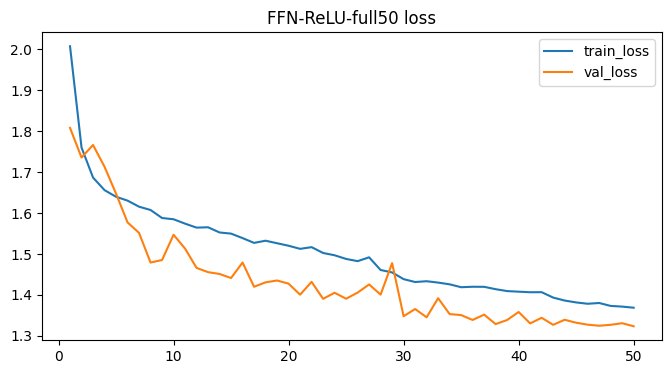

<Figure size 640x480 with 0 Axes>

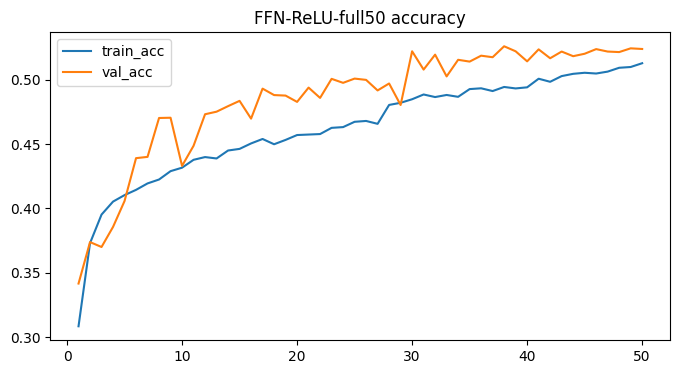

Saved plots to plots


<Figure size 640x480 with 0 Axes>

In [18]:
# Train the model for full 50 epochs (may take long; GPU recommended)
full_epochs = 50
history_full, ckpt_path_full, metrics_full = train_and_evaluate(model, 'FFN-ReLU-full50', epochs=full_epochs, batch_size=HPARAMS['batch_size'])
print('Checkpoint saved to:', ckpt_path_full)
metrics_full

# Save and plot training curves for the full run
try:
    plot_and_save_history(history_full, 'FFN-ReLU-full50')
except Exception as e:
    print('Plotting failed:', e)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5239
Accuracy: 0.5239
Precision (macro): 0.5238546744308685
Recall (macro): 0.5238999999999999
F1 (macro): 0.5171975557795394

Classification report:
               precision    recall  f1-score   support

           0     0.6437    0.5240    0.5777      1000
           1     0.6646    0.6300    0.6468      1000
           2     0.4132    0.3930    0.4029      1000
           3     0.3706    0.2620    0.3070      1000
           4     0.4977    0.4280    0.4602      1000
           5     0.4690    0.3860    0.4235      1000
           6     0.4505    0.7190    0.5539      1000
           7     0.5798    0.5850    0.5824      1000
           8     0.5602    0.7440    0.6392      1000
           9     0.5892    0.5680    0.5784      1000

    accuracy                         0.5239     10000
   macro avg     0.5239    0.5239    0.5172     10000
weighted avg     0.5239    0.5239    0.5172     100

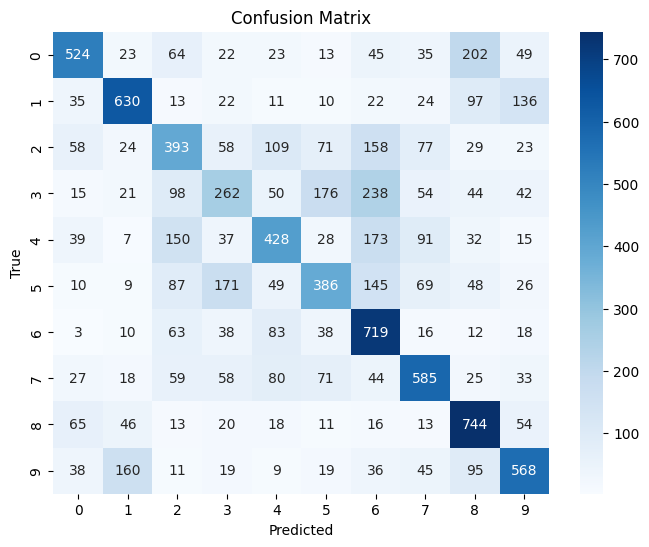

In [22]:
# Evaluation: classification report + confusion matrix
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test.reshape(-1)
print('Accuracy:', np.mean(y_true == y_pred))
print('Precision (macro):', precision_score(y_true, y_pred, average='macro'))
print('Recall (macro):', recall_score(y_true, y_pred, average='macro'))
print('F1 (macro):', f1_score(y_true, y_pred, average='macro'))
print('\nClassification report:\n', classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

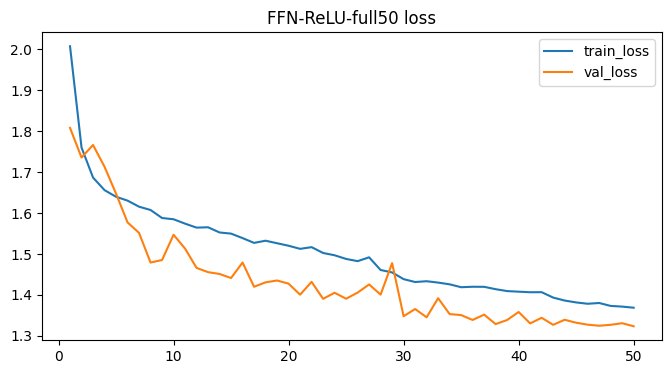

<Figure size 640x480 with 0 Axes>

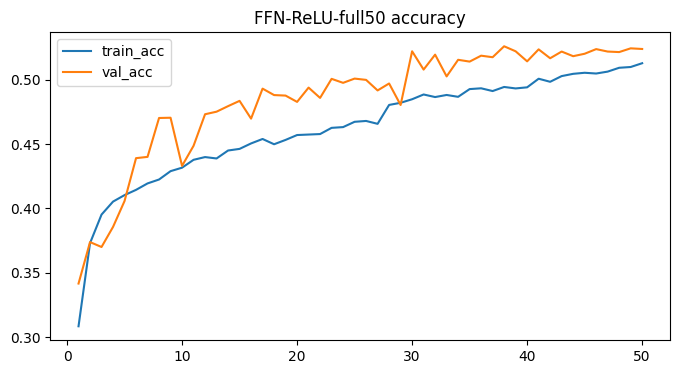

Saved plots to plots


<Figure size 640x480 with 0 Axes>

In [23]:
# Plot and save training curves
os.makedirs('plots', exist_ok=True)
def plot_and_save_history(history, name='model', outdir='plots'):
    if history is None: return
    h = history.history
    epochs = range(1, len(h.get('loss', [])) + 1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, h.get('loss', []), label='train_loss')
    plt.plot(epochs, h.get('val_loss', []), label='val_loss')
    plt.legend(); plt.title(f'{name} loss'); plt.show()
    plt.savefig(os.path.join(outdir, f'{name}_loss.png'), bbox_inches='tight')
    plt.figure(figsize=(8,4))
    plt.plot(epochs, h.get('accuracy', h.get('acc', [])), label='train_acc')
    plt.plot(epochs, h.get('val_accuracy', h.get('val_acc', [])), label='val_acc')
    plt.legend(); plt.title(f'{name} accuracy'); plt.show()
    plt.savefig(os.path.join(outdir, f'{name}_acc.png'), bbox_inches='tight')
    print('Saved plots to', outdir)

# If a full run variable exists, save that; otherwise attempt the default 'history'
if 'history_full' in globals():
    try:
        plot_and_save_history(history_full, 'FFN-ReLU-full50')
    except Exception as e:
        print('Plotting full history failed:', e)
elif 'history' in globals():
    try:
        plot_and_save_history(history, 'FFN-ReLU')
    except Exception as e:
        print('Plotting history failed:', e)
else:
    print('No history object found to plot')


## Minimal NumPy backpropagation demo (educational)
This demonstrates forward/backward update on a small subset (short run).

In [24]:
# Small subset demo
subset = 2000
X_small = x_train[:subset].reshape(subset, -1)
Y_small = y_train_cat[:subset]
def softmax(z):
    e = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)
input_dim = X_small.shape[1]; hidden = 128; out = num_classes; lr = 1e-3
np.random.seed(HPARAMS['seed'])
W1 = np.random.randn(input_dim, hidden) * np.sqrt(2.0/(input_dim+hidden))
b1 = np.zeros((1, hidden))
W2 = np.random.randn(hidden, out) * np.sqrt(2.0/(hidden+out))
b2 = np.zeros((1, out))
for epoch in range(3):
    z1 = X_small.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = softmax(z2)
    m = Y_small.shape[0]
    loss = -np.sum(Y_small * np.log(a2 + 1e-12)) / m
    dz2 = (a2 - Y_small) / m
    dW2 = a1.T.dot(dz2); db2 = np.sum(dz2, axis=0, keepdims=True)
    da1 = dz2.dot(W2.T)
    dz1 = da1 * (1 - np.tanh(z1)**2)
    dW1 = X_small.T.dot(dz1); db1 = np.sum(dz1, axis=0, keepdims=True)
    W2 -= lr * dW2; b2 -= lr * db2
    W1 -= lr * dW1; b1 -= lr * db1
    print(f'Demo epoch {epoch+1}, loss: {loss:.4f}')

Demo epoch 1, loss: 2.4565
Demo epoch 2, loss: 2.4397
Demo epoch 3, loss: 2.4244


## Optimization strategies & weight initialization (summary)
- Use EarlyStopping + ReduceLROnPlateau to avoid overfitting and adapt learning rate.
- ModelCheckpoint saves best model by validation loss.
- Initialize weights with scaled random (Xavier/He) to avoid vanishing/exploding gradients.

For full assignment: set `HPARAMS['epochs']=50` and run in a GPU-enabled environment for reasonable training time.